# Results from WandB


## Imports

In [1]:
import wandb
from community.utils.wandb_utils import get_wandb_artifact, get_wandb_runs
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import json
import seaborn as sns

## Load Results

In [12]:
sweep_path = 'gbena/funcspec/j3uqaib0'
sweep_id = sweep_path.split('/')[-1]
total_data = pd.read_pickle(f'../../results/sweep_tables/{sweep_id}')
total_data.columns, total_data.shape

(Index(['Step', 'best_acc', 'n_hidden', 'sparsity', 'mean_corr_det',
        'mean_corr_det_norm_1', 'mean_corr_det_norm_2',
        'mean_corr_det_norm_fro', 'mean_corr_global_diff', 'bottleneck_det',
        'bottleneck_det_norm_1', 'bottleneck_det_norm_2',
        'bottleneck_det_norm_fro', 'bottleneck_global_diff', 'name'],
       dtype='object'),
 (1020, 15))

## Plot Smooth Heatmap

In [13]:
filtered_data = total_data[(total_data['Step'] == 1)]
filtered_data.shape

(510, 15)

In [63]:
y_values, x_values, z_values_diff, z_values_det = filtered_data[['sparsity', 'n_hidden', 'bottleneck_global_diff', 'bottleneck_det']].values.T

In [93]:
def compute_and_plot(x_values, y_values, z_values, y_log=False) : 


    ratio = (y_values/x_values).mean() * 2
    smoothness = 0.3
    resolution = 300


    sigmas = np.array([1, ratio])*smoothness

    def gaussian_filter(x, y, sigmas=sigmas) : 
        
        return np.exp(-(x**2/sigmas[0]**2 + y**2/sigmas[1]**2))
        
    def weighted_average(x, y, sigmas=sigmas) : 

        return (z_values * gaussian_filter(x - x_values, y - y_values, sigmas)).sum() / gaussian_filter(x - x_values, y - y_values, sigmas).sum()

    vect_avg = np.vectorize(weighted_average, signature=('(),()->()'))

    def plot_filter(sigmas) :
        Y = np.linspace(1e-5, 1, 200)
        X = np.linspace(5, 50, 200)

        point = (10, .5)

        filter = lambda x, y : gaussian_filter( (x - point[0]), y - point[1], sigmas=sigmas).mean()
        Z = np.array([[filter(x, y) for x in X] for y in Y])
        sns.heatmap(Z)

    if not y_log : 
        Y = np.linspace(y_values.min(), y_values.max(), resolution) #500 x 500 takes 10s
    else : 
        Y = np.logspace(np.log10(y_values.min()), np.log10(y_values.max()), resolution)
        print(Y)

    X = np.linspace(x_values.min(), x_values.max(), resolution)
    Xm, Ym = np.meshgrid(X, Y)
    Z = vect_avg(Xm, Ym)

    plt.figure(figsize=(20, 10))
    plt.pcolormesh(X, Y, Z, cmap='viridis')
    #plt.yscale('log')
    #plt.grid(True)
    plt.colorbar()

[0.001      0.00102337 0.00104729 0.00107177 0.00109682 0.00112245
 0.00114868 0.00117553 0.00120301 0.00123112 0.0012599  0.00128934
 0.00131948 0.00135031 0.00138187 0.00141417 0.00144722 0.00148105
 0.00151566 0.00155108 0.00158734 0.00162444 0.0016624  0.00170125
 0.00174102 0.00178171 0.00182335 0.00186596 0.00190957 0.0019542
 0.00199988 0.00204662 0.00209445 0.0021434  0.0021935  0.00224476
 0.00229723 0.00235092 0.00240586 0.00246209 0.00251964 0.00257852
 0.00263879 0.00270046 0.00276358 0.00282817 0.00289427 0.00296191
 0.00303114 0.00310198 0.00317448 0.00324867 0.0033246  0.0034023
 0.00348182 0.00356319 0.00364647 0.0037317  0.00381891 0.00390817
 0.00399951 0.00409298 0.00418865 0.00428654 0.00438673 0.00448925
 0.00459417 0.00470155 0.00481143 0.00492388 0.00503896 0.00515673
 0.00527725 0.00540059 0.00552681 0.00565599 0.00578818 0.00592346
 0.0060619  0.00620358 0.00634857 0.00649694 0.00664879 0.00680418
 0.00696321 0.00712595 0.0072925  0.00746294 0.00763736 0.007815

/tmp/ipykernel_9054/1614841287.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return (z_values * gaussian_filter(x - x_values, y - y_values, sigmas)).sum() / gaussian_filter(x - x_values, y - y_values, sigmas).sum()


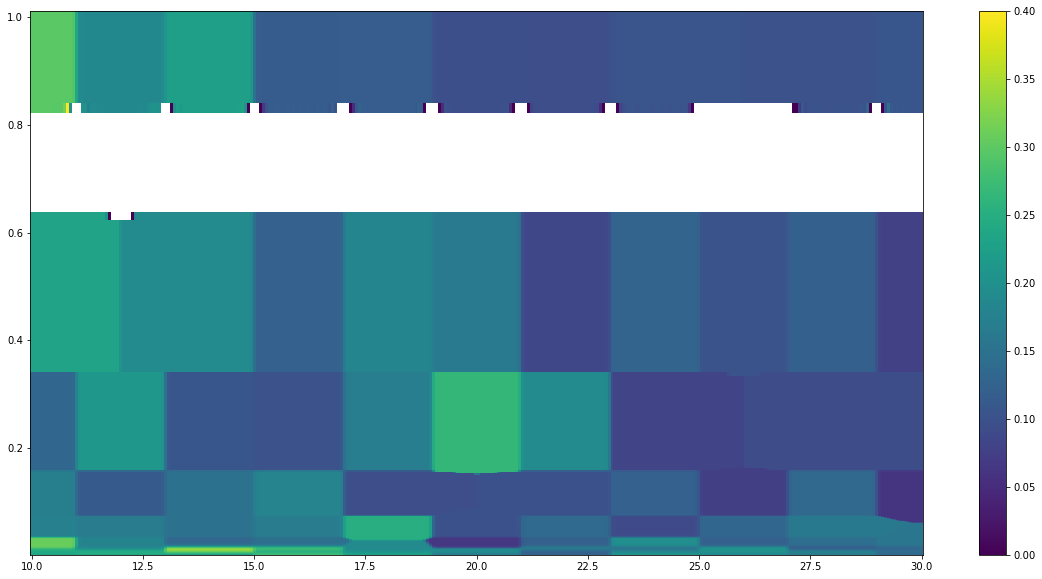

In [94]:
compute_and_plot(x_values, y_values, z_values_diff, True)

In [114]:
np.sort(np.unique(np.concatenate((np.linspace(0, 0.2, 11), np.linspace(0.2, 1, 11, )))))

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.28, 0.36, 0.44, 0.52, 0.6 , 0.68, 0.76, 0.84, 0.92, 1.  ])

In [115]:
np.geomspace(1e-3, 1, 21)

array([0.001     , 0.00141254, 0.00199526, 0.00281838, 0.00398107,
       0.00562341, 0.00794328, 0.01122018, 0.01584893, 0.02238721,
       0.03162278, 0.04466836, 0.06309573, 0.08912509, 0.12589254,
       0.17782794, 0.25118864, 0.35481339, 0.50118723, 0.70794578,
       1.        ])

In [120]:
len(np.unique(np.geomspace(10, 50, 20, dtype=int)))

19

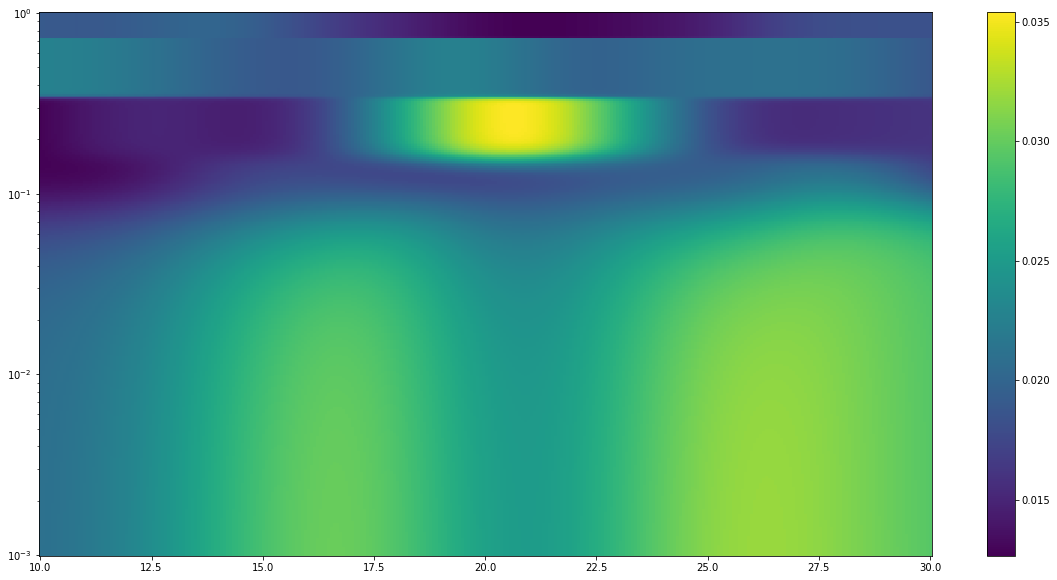

In [80]:
compute_and_plot(x_values, y_values, z_values_det, True)

In [9]:
np.linspace(10, 30, 11)

array([10., 12., 14., 16., 18., 20., 22., 24., 26., 28., 30.])

In [10]:
1/20**2

0.0025

In [11]:
plt.plot(filter(5, 0.1))

TypeError: 'float' object is not iterable